In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import chess

tablero = chess.Board()

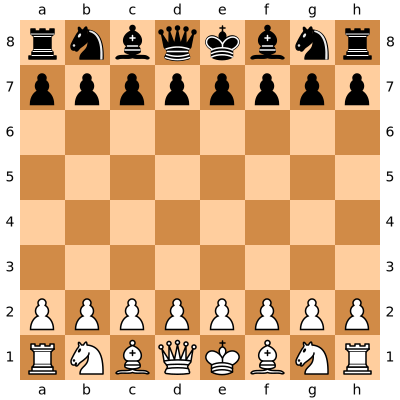

In [3]:
tablero

In [4]:
from keras.models import load_model

model1 = load_model('/content/drive/My Drive/Chess/model64_2ep64.h5')

model2 = load_model('/content/drive/My Drive/Chess/model64_0_1.h5')

In [5]:
import numpy as np

##Enlace con la database
def tablero_a_nums(fen_str):
    tablero_str, _, _, _, _, _ = fen_str.split(" ")
    for i in range(1, 9):
        tablero_str = tablero_str.replace(str(i), '.' * i).replace('/', '')
    piezas = ['.', 'P', 'N', 'B', 'R', 'Q', 'K', 'p', 'n', 'b', 'r', 'q', 'k']
    tablero_array = np.zeros(64)
    for i, elemento in enumerate(tablero_str):
        tablero_array[i] = piezas.index(elemento)
    return tablero_array

##Evaluador de nodos

def evaluate_position1(tablero):
    fen = tablero.fen()
    tablero_array = tablero_a_nums(fen)
    return model1.predict(np.asarray([tablero_array]))

def evaluate_position2(tablero):
    fen = tablero.fen()
    tablero_array = tablero_a_nums(fen)
    return model2.predict(np.asarray([tablero_array]))

In [6]:
class Node:
    
    def __init__(self, state, move=None, parent=None):
        self.move = move
        self.state = state
        self.parent = parent
        self.unexplored_moves = list(state.legal_moves)
        self.children = []
        self.visits = 0
        self.wins = 0
        
    def add_child(self, state, move):
        child_node = Node(state, move, self)
        self.children.append(child_node)
        self.unexplored_moves.remove(move)
        return child_node
        
    def UCT_select_child(self):
        s = sorted(self.children, key = lambda c: c.wins/c.visits + sqrt(2*log(self.visits)/c.visits) )[-1]
        return s
    
    def Update(self, result):
        self.visits += 1
        self.wins += result ###valor de victoria obtenida de la inteligencia artificial

In [7]:
import random
from math import sqrt, log
def UCT1(rootstate, itermax, depthmax):
    rootnode = Node(state = rootstate)
    for i in range(itermax):
        node = rootnode
        depth = 0
        state = rootstate.copy()

        # Selección
        while node.unexplored_moves == [] and node.children != []: # El nodo se ha expandido completamente
            node = node.UCT_select_child()
            state.push(node.move)

        # Expansión
        if node.unexplored_moves != []: # Si podemos seguir expandiendo
            m = random.choice(node.unexplored_moves) 
            state.push(m)
            node = node.add_child(state,m) # Añadir un hijo y seguir con el árbol 
            depth += 1

        # Simulación
        while list(state.legal_moves) != [] and depth < depthmax: # Mientras el estado permita
            state.push(random.choice(list(state.legal_moves)))
            depth += 1

        # Actualización
        while node != None: # Actualización del nodo expandido y se realiza la propagación hasta el nodo raíz 
            result = evaluate_position1(state)
            #print(result)   para ver los valores de los nodos en tiempo real
            clear_output(wait=True) 
            node.Update(result) #se actualiza el estado del nodo
            node = node.parent

    return sorted(rootnode.children, key = lambda c: c.visits)[-1].move

In [8]:
import random
from math import sqrt, log
def UCT2(rootstate, itermax, depthmax):
    rootnode = Node(state = rootstate)
    for i in range(itermax):
        node = rootnode
        depth = 0
        state = rootstate.copy()

        # Selección
        while node.unexplored_moves == [] and node.children != []: # El nodo se ha expandido completamente
            node = node.UCT_select_child()
            state.push(node.move)

        # Expansión
        if node.unexplored_moves != []: # Si podemos seguir expandiendo
            m = random.choice(node.unexplored_moves) 
            state.push(m)
            node = node.add_child(state,m) # Añadir un hijo y seguir con el árbol 
            depth += 1

        # Simulación
        while list(state.legal_moves) != [] and depth < depthmax: # Mientras el estado permita
            state.push(random.choice(list(state.legal_moves)))
            depth += 1

        # Actualización
        while node != None: # Actualización del nodo expandido y se realiza la propagación hasta el nodo raíz 
            result = evaluate_position2(state)
            node.Update(result)
            node = node.parent

    return sorted(rootnode.children, key = lambda c: c.visits)[-1].move

In [9]:
import time
from IPython.display import clear_output, display
import chess.pgn

tablero = chess.Board()

def play_game(player1, player2):
    while not tablero.is_game_over():
        if tablero.turn == chess.WHITE:
            player1(tablero)
        else:
            player2(tablero)
        clear_output(wait=True)
        display(tablero)
        time.sleep(0.01)
    game = chess.pgn.Game.from_board(tablero)
    print(game)

In [10]:
import random

def mcts_player1(tablero):
    move = None
    for move_choice in tablero.legal_moves:
        copy = tablero.copy()
        copy.push(move_choice)
        if copy.is_game_over():
            move = move_choice
            tablero.push(move)
            return
    if random.random() < 0.01:
        move = random.choice(list(tablero.legal_moves))
    else:
        move = UCT1(tablero, 64, 100)
    tablero.push(move)

def mcts_player2(tablero):
    move = None
    for move_choice in tablero.legal_moves:
        copy = tablero.copy()
        copy.push(move_choice)
        if copy.is_game_over():
            move = move_choice
            tablero.push(move)
            return
    move = UCT2(tablero, 64, 300)
    tablero.push(move)

def random_play(tablero):
  move = random.choice(list(tablero.legal_moves))
  tablero.push(move)

In [14]:
def human_player(tablero):
    while True:
        print(tablero.legal_moves )
        move = input("Cual es tu jugada: \n" )
        if move == "q":
            raise KeyboardInterrupt
        try:
            tablero.push_san(move)
            break 
        except Exception as e:
            print(e)

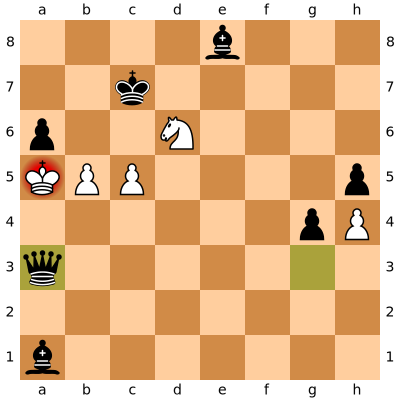

[Event "?"]
[Site "?"]
[Date "????.??.??"]
[Round "?"]
[White "?"]
[Black "?"]
[Result "0-1"]

1. b3 Nf6 2. Ba3 Rg8 3. Bd6 Nc6 4. Bb4 e5 5. f4 Nxb4 6. Qc1 b5 7. fxe5 Nfd5 8. Kf2 Nb6 9. Na3 Qe7 10. c4 Rh8 11. Qb2 Qh4+ 12. g3 Nc2 13. Nxc2 Ba3 14. Re1 Qe4 15. Nh3 g5 16. Ng1 c6 17. Ra1 Na4 18. h4 d6 19. Nb4 g4 20. Nh3 Bxb2 21. Bg2 Bxa1 22. Nc2 Qxe2+ 23. Kg1 Rg8 24. c5 Nxc5 25. Bf3 Ba6 26. b4 Rf8 27. Na3 Qh2+ 28. Kf1 O-O-O 29. Ke1 Kd7 30. Rf1 Ra8 31. Kd1 h5 32. Ng5 Qg1 33. Kc1 Rfc8 34. exd6 Na4 35. Bg2 Rf8 36. Bh3 Nb2 37. Nc2 Qg2 38. Nxf7 Rae8 39. a3 c5 40. Ne3 Qh1 41. Nc4 Kc8 42. a4 Rxf7 43. Na5 Re3 44. d4 Ree7 45. dxe7 Qb7 46. Rh1 Qg2 47. axb5 Qxh1+ 48. Bf1 Rf3 49. e8=Q+ Kc7 50. Kb1 Bb7 51. Qe1 Bc6 52. Ka2 Qh2 53. Nb7 Rf7 54. Ka3 Be8 55. Bd3 Rf2 56. Qc1 Qg1 57. Qb1 Rf5 58. Qf1 Nxd3 59. dxc5 Qg2 60. Qxf5 Ne5 61. Qh7+ Kc8 62. Qg6 Qg1 63. Qc2 Qf1 64. Kb3 Qf3+ 65. Ka4 Nd3 66. Qc3 Qe3 67. Qe5 Qxg3 68. Qc7+ Kxc7 69. Nd6 Nxc5+ 70. bxc5 a6 71. Ka5 Qa3# 0-1


In [12]:
tablero = chess.Board()

play_game(mcts_player1, mcts_player2)

In [ ]:
tablero = chess.Board()

play_game(human_player, mcts_player1)

In [ ]:
tablero = chess.Board()

play_game(random_play, mcts_player2)